# 1. Import Libraries and Packages

In [87]:
import numpy as np
import pandas as pd
from scipy import stats
from util import plot_helper
from util import iv_helper
from util import LC_customize

import matplotlib.pyplot as plt

%matplotlib inline

# 2. Load, View, Filter, Sample Dataset

## Create full accepted dataset

In [88]:
# accept = pd.read_csv('data/accepted_2007_to_2018Q3.csv', low_memory=False)

# accept.head()
# accept = accept.loc[accept['loan_status'].isin(['Fully Paid', 'Charged Off'])]
# accept['loan_status'].value_counts()
# accept.to_csv('data/accepted_loan.csv')


# output:
#     Fully Paid     1011841
#     Charged Off     254777
#     Name: loan_status, dtype: int64

In [89]:
# accept['loan_status'].unique().tolist()

# output:
# ['Current',
#  'Fully Paid',
#  'Charged Off',
#  'Late (31-120 days)',
#  'In Grace Period',
#  'Late (16-30 days)',
#  'Default',
#  nan,
#  'Does not meet the credit policy. Status:Fully Paid',
#  'Does not meet the credit policy. Status:Charged Off']

In [90]:
# Replace null value in source data with unkown, will be regarded as "Charged Off"
# accept['loan_status'] = accept['loan_status'].fillna('unkown')

In [91]:
# accept['loan_status'].value_counts()

# Fully Paid                                             1011841
# Current                                                 822105
# Charged Off                                             254777
# Late (31-120 days)                                       22852
# In Grace Period                                          12458
# Late (16-30 days)                                         5442
# Does not meet the credit policy. Status:Fully Paid        1988
# Does not meet the credit policy. Status:Charged Off        761
# Default                                                     32
# unkown                                                      31
# Name: loan_status, dtype: int64

## Create sampling dataset

In [92]:
# # Extract and sample good loan and bad loan data
# loan_good = accept.loc[accept['loan_status'].isin(['Fully Paid','Does not meet the credit policy. Status:Fully Paid'])]
# loan_good.to_csv('data/loan_good.csv')

# loan_bad = accept.loc[accept['loan_status'].isin(['Charged Off','Late (31-120 days)','Late (16-30 days)','Default','unknown','Does not meet the credit policy. Status:Charged Off'])]
# loan_bad.to_csv('data/loan_bad.csv')


In [93]:
# # Sampling 1% data

# loan_good = pd.read_csv('data/loan_good.csv', low_memory=False)
# loan_bad = pd.read_csv('data/loan_bad.csv', low_memory=False)

# loan_sample = pd.concat([loan_good.sample(frac = 0.01), loan_bad.sample(frac = 0.01)], ignore_index=True)
# loan_sample.to_csv('data/loan_sample_1pct.csv')


In [94]:
# # Sampling 10% data

# loan_good = pd.read_csv('data/loan_good.csv', low_memory=False)
# loan_bad = pd.read_csv('data/loan_bad.csv', low_memory=False)

# loan_sample = pd.concat([loan_good.sample(frac = 0.1), loan_bad.sample(frac = 0.1)], ignore_index=True)
# loan_sample.to_csv('data/loan_sample_10pct.csv')


In [95]:
# Load 1% sampling data
# loan_sample = pd.read_csv('data/loan_sample_1pct.csv', low_memory=False)

In [96]:
# # Load 10% sampling data
loan_sample = pd.read_csv('data/loan_sample_10pct.csv', low_memory=False)

In [97]:
# Load all accepted loan data.
# loan_sample = pd.read_csv('data/accepted_loan.csv',low_memory=False)

In [98]:
# loan_sample.describe()

# 3. Select features

## Check missing data fractions

In [99]:
missing_fractions = loan_sample.isnull().mean().sort_values(ascending=False)
missing_fractions.head(5)

member_id                                     1.000000
orig_projected_additional_accrued_interest    0.996317
sec_app_mths_since_last_major_derog           0.994883
hardship_length                               0.994822
hardship_type                                 0.994822
dtype: float64

In [100]:
ft = sorted(missing_fractions.items(), key=lambda x: x[1], reverse=True)
# type(ft)
# type(ft[0])

Text(0, 0.5, 'missing ratio')

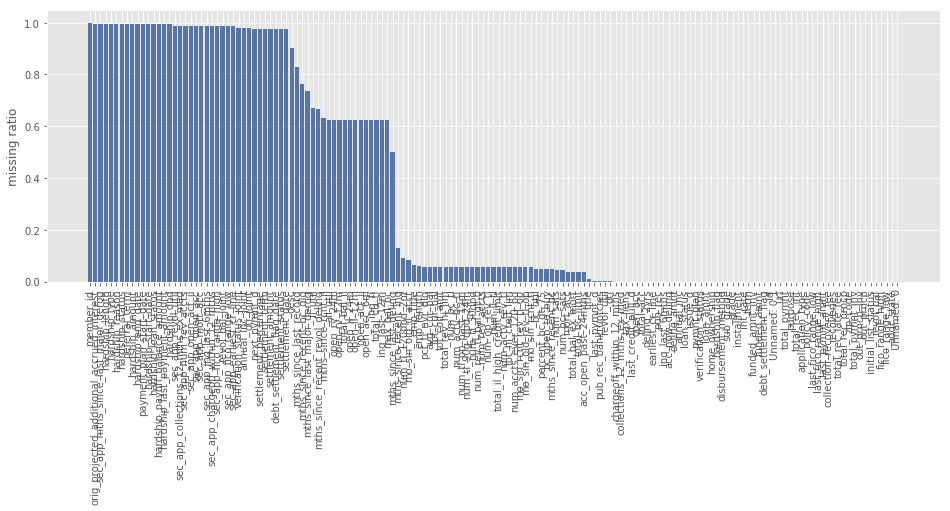

In [101]:
plt.figure(figsize=(16, 5))
xs = [x[0] for x in ft]
ys = [x[1] for x in ft]
plt.bar(xs, ys, color='#5975A4')
plt.xticks(rotation=90)
plt.ylabel('missing ratio')

In [102]:
# missing_fractions

In [103]:
# for x in ft:
#     if x[1] < 0.2:
#         print(x[0],x[1])

In [104]:
# for x in ft:
#     if x[1] < 0.2:
#         print(x[0])

## Choose features which null value less than 20%

In [105]:
ft_select = [x[0] for x in missing_fractions.items() if x[1] < 0.2]

In [106]:
len(ft_select)

95

## Create new data frame with selected features

In [107]:
loan_sample_ft = loan_sample[ft_select]

In [108]:
loan_sample_ft.describe()

,mths_since_recent_inq,num_tl_120dpd_2m,mo_sin_old_il_acct,pct_tl_nvr_dlq,avg_cur_bal,tot_cur_bal,tot_coll_amt,total_rev_hi_lim,num_bc_tl,num_actv_bc_tl,...,recoveries,total_rec_late_fee,total_rec_prncp,total_pymnt_inv,out_prncp_inv,out_prncp,revol_bal,fico_range_high,fico_range_low,Unnamed: 0
count,112768.000000,117912.000000,119074.000000,122710.000000,122721.000000,1.227220e+05,122722.000000,1.227220e+05,122722.000000,122722.000000,...,129769.000000,1.297690e+05,129769.000000,129769.000000,129769.000000,129769.000000,1.297690e+05,129769.000000,129769.000000,129769.000000
mean,6.694532,0.000933,125.825386,94.140462,13493.826362,1.413892e+05,229.777277,3.274859e+04,8.148645,3.653648,...,233.817090,1.800038e+00,12000.014455,14607.915387,241.993960,242.061349,1.635161e+04,699.817399,695.817183,64884.000000
std,5.856154,0.033446,52.071013,8.733103,16347.935072,1.576898e+05,1802.047043,3.383026e+04,4.827337,2.252458,...,937.666548,1.235198e+01,8824.099717,10290.024215,2040.824253,2041.249773,2.298919e+04,31.672881,31.671862,37461.227879
min,0.000000,0.000000,0.000000,10.700000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,-2.000000e-10,0.000000,0.000000,0.000000,0.000000,0.000000e+00,624.000000,620.000000,0.000000
25%,2.000000,0.000000,98.000000,91.300000,3115.000000,2.976825e+04,0.000000,1.400000e+04,5.000000,2.000000,...,0.000000,0.000000e+00,5000.000000,6691.650000,0.000000,0.000000,5.943000e+03,674.000000,670.000000,32442.000000
50%,5.000000,0.000000,129.000000,97.800000,7423.000000,8.038600e+04,0.000000,2.400000e+04,7.000000,3.000000,...,0.000000,0.000000e+00,10000.000000,11949.840000,0.000000,0.000000,1.116500e+04,694.000000,690.000000,64884.000000
75%,10.000000,0.000000,152.000000,100.000000,18706.000000,2.108052e+05,0.000000,4.062850e+04,11.000000,5.000000,...,0.000000,0.000000e+00,17000.000000,20310.980000,0.000000,0.000000,1.988300e+04,714.000000,710.000000,97326.000000
max,25.000000,4.000000,555.000000,100.000000,447433.000000,4.026405e+06,169257.000000,1.998700e+06,65.000000,32.000000,...,39444.370000,9.357000e+02,40000.000000,61720.490000,40000.000000,40000.000000,1.746716e+06,850.000000,845.000000,129768.000000


In [109]:
loan_sample_ft.head()

,mths_since_recent_inq,num_tl_120dpd_2m,mo_sin_old_il_acct,emp_title,emp_length,pct_tl_nvr_dlq,avg_cur_bal,tot_cur_bal,tot_coll_amt,total_rev_hi_lim,...,zip_code,total_pymnt_inv,out_prncp_inv,out_prncp,initial_list_status,revol_bal,fico_range_high,fico_range_low,addr_state,Unnamed: 0
0,0.0,0.0,93.0,Financial Counselor,9 years,96.6,36431.0,400738.0,0.0,27900.0,...,919xx,7563.01,0.0,0.0,w,10982.0,719.0,715.0,CA,0
1,1.0,0.0,120.0,NaN,2 years,88.0,4326.0,21628.0,0.0,18700.0,...,951xx,17692.65,0.0,0.0,f,11350.0,664.0,660.0,CA,1
2,8.0,0.0,60.0,Jon Don Inc,9 years,94.0,21254.0,276305.0,0.0,35400.0,...,346xx,10819.48,0.0,0.0,w,2449.0,754.0,750.0,FL,2
3,6.0,0.0,102.0,ice contractors,8 years,100.0,11980.0,107816.0,0.0,15500.0,...,356xx,7748.98,0.0,0.0,f,7019.0,704.0,700.0,AL,3
4,11.0,0.0,56.0,Lead Pastor,6 years,100.0,2990.0,14950.0,0.0,44600.0,...,760xx,12225.04,0.0,0.0,w,14950.0,729.0,725.0,TX,4


# Replace missing values

In [110]:
# Do not drop rows with null value
# Remove rows with null value.
# loan_sample_ft_dn = loan_sample_ft.dropna()

In [111]:
loan_sample_ft.columns.tolist()

['mths_since_recent_inq',
 'num_tl_120dpd_2m',
 'mo_sin_old_il_acct',
 'emp_title',
 'emp_length',
 'pct_tl_nvr_dlq',
 'avg_cur_bal',
 'tot_cur_bal',
 'tot_coll_amt',
 'total_rev_hi_lim',
 'num_bc_tl',
 'num_actv_bc_tl',
 'num_tl_op_past_12m',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_rev_tl_bal_gt_0',
 'num_rev_accts',
 'num_op_rev_tl',
 'num_il_tl',
 'total_il_high_credit_limit',
 'num_actv_rev_tl',
 'tot_hi_cred_lim',
 'num_accts_ever_120_pd',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_tl',
 'bc_util',
 'percent_bc_gt_75',
 'bc_open_to_buy',
 'mths_since_recent_bc',
 'num_sats',
 'num_bc_sats',
 'mort_acc',
 'total_bal_ex_mort',
 'total_bc_limit',
 'acc_open_past_24mths',
 'title',
 'last_pymnt_d',
 'pub_rec_bankruptcies',
 'revol_util',
 'dti',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'tax_liens',
 'last_credit_pull_d',
 'open_acc',
 'total_acc',
 'delinq_2yrs',
 'earliest_cr_line',
 'pub_rec',
 'inq_last_6mths',
 'acc_now_delinq',
 'de

## Handle with null values

### Replace null value for numerical features with 0 or median or mode.

In [112]:
numerical_ft=list(loan_sample_ft.dtypes.loc[lambda x : x == 'float64'].to_dict().keys())
len(numerical_ft)
# for feature_name in numerical_ft:
#    loan_sample_ft[feature_name] = loan_sample_ft[feature_name].fillna(loan_sample_ft[feature_name].median())
    

69

In [113]:
numerical_ft

['mths_since_recent_inq',
 'num_tl_120dpd_2m',
 'mo_sin_old_il_acct',
 'pct_tl_nvr_dlq',
 'avg_cur_bal',
 'tot_cur_bal',
 'tot_coll_amt',
 'total_rev_hi_lim',
 'num_bc_tl',
 'num_actv_bc_tl',
 'num_tl_op_past_12m',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_rev_tl_bal_gt_0',
 'num_rev_accts',
 'num_op_rev_tl',
 'num_il_tl',
 'total_il_high_credit_limit',
 'num_actv_rev_tl',
 'tot_hi_cred_lim',
 'num_accts_ever_120_pd',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_tl',
 'bc_util',
 'percent_bc_gt_75',
 'bc_open_to_buy',
 'mths_since_recent_bc',
 'num_sats',
 'num_bc_sats',
 'mort_acc',
 'total_bal_ex_mort',
 'total_bc_limit',
 'acc_open_past_24mths',
 'pub_rec_bankruptcies',
 'revol_util',
 'dti',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'tax_liens',
 'open_acc',
 'total_acc',
 'delinq_2yrs',
 'pub_rec',
 'inq_last_6mths',
 'acc_now_delinq',
 'delinq_amnt',
 'annual_inc',
 'loan_amnt',
 'installment',
 'int_rate',
 'funded_amnt_inv',
 'funded_a

In [114]:
loan_sample_ft['total_rev_hi_lim'].head(10)

0    27900.0
1    18700.0
2    35400.0
3    15500.0
4    44600.0
5    70500.0
6    61700.0
7    47200.0
8    21700.0
9    53800.0
Name: total_rev_hi_lim, dtype: float64

In [115]:
# # Replace with 0
# loan_sample_ft['num_tl_120dpd_2m'] = np.where(loan['num_tl_120dpd_2m'].isnull(), 0, loan['num_tl_120dpd_2m'])

# # Replace with median
# loan_sample_ft['tot_cur_bal'] = loan_sample_ft['tot_cur_bal'].fillna(loan_sample_ft['tot_cur_bal'].median())

# # Replace with mode
# loan_sample_ft['policy_code'] = loan_sample_ft['policy_code'].fillna(loan_sample_ft['policy_code'].mode())

### Replace numerical feature value with 0

In [116]:
loan_sample_ft['mths_since_recent_inq'] = np.where(loan_sample_ft['mths_since_recent_inq'].isnull(), 0, loan_sample_ft['mths_since_recent_inq'])
loan_sample_ft['num_tl_120dpd_2m'] = np.where(loan_sample_ft['num_tl_120dpd_2m'].isnull(), 0, loan_sample_ft['num_tl_120dpd_2m'])
loan_sample_ft['mo_sin_old_il_acct'] = np.where(loan_sample_ft['mo_sin_old_il_acct'].isnull(), 0, loan_sample_ft['mo_sin_old_il_acct'])
loan_sample_ft['num_il_tl'] = np.where(loan_sample_ft['num_il_tl'].isnull(), 0, loan_sample_ft['num_il_tl'])
loan_sample_ft['num_tl_30dpd'] = np.where(loan_sample_ft['num_tl_30dpd'].isnull(), 0, loan_sample_ft['num_tl_30dpd'])
loan_sample_ft['num_rev_accts'] = np.where(loan_sample_ft['num_rev_accts'].isnull(), 0, loan_sample_ft['num_rev_accts'])
loan_sample_ft['num_rev_tl_bal_gt_0'] = np.where(loan_sample_ft['num_rev_tl_bal_gt_0'].isnull(), 0, loan_sample_ft['num_rev_tl_bal_gt_0'])
loan_sample_ft['num_op_rev_tl'] = np.where(loan_sample_ft['num_op_rev_tl'].isnull(), 0, loan_sample_ft['num_op_rev_tl'])
loan_sample_ft['num_bc_tl'] = np.where(loan_sample_ft['num_bc_tl'].isnull(), 0, loan_sample_ft['num_bc_tl'])
loan_sample_ft['num_actv_rev_tl'] = np.where(loan_sample_ft['num_actv_rev_tl'].isnull(), 0, loan_sample_ft['num_actv_rev_tl'])
loan_sample_ft['num_actv_bc_tl'] = np.where(loan_sample_ft['num_actv_bc_tl'].isnull(), 0, loan_sample_ft['num_actv_bc_tl'])
loan_sample_ft['num_accts_ever_120_pd'] = np.where(loan_sample_ft['num_accts_ever_120_pd'].isnull(), 0, loan_sample_ft['num_accts_ever_120_pd'])
loan_sample_ft['num_tl_op_past_12m'] = np.where(loan_sample_ft['num_tl_op_past_12m'].isnull(), 0, loan_sample_ft['num_tl_op_past_12m'])
loan_sample_ft['mo_sin_rcnt_tl'] = np.where(loan_sample_ft['mo_sin_rcnt_tl'].isnull(), 0, loan_sample_ft['mo_sin_rcnt_tl'])
loan_sample_ft['mo_sin_rcnt_rev_tl_op'] = np.where(loan_sample_ft['mo_sin_rcnt_rev_tl_op'].isnull(), 0, loan_sample_ft['mo_sin_rcnt_rev_tl_op'])
loan_sample_ft['mo_sin_old_rev_tl_op'] = np.where(loan_sample_ft['mo_sin_old_rev_tl_op'].isnull(), 0, loan_sample_ft['mo_sin_old_rev_tl_op'])
loan_sample_ft['num_tl_90g_dpd_24m'] = np.where(loan_sample_ft['num_tl_90g_dpd_24m'].isnull(), 0, loan_sample_ft['num_tl_90g_dpd_24m'])
loan_sample_ft['bc_open_to_buy'] = np.where(loan_sample_ft['bc_open_to_buy'].isnull(), 0, loan_sample_ft['bc_open_to_buy'])
loan_sample_ft['mths_since_recent_bc'] = np.where(loan_sample_ft['mths_since_recent_bc'].isnull(), 0, loan_sample_ft['mths_since_recent_bc'])
loan_sample_ft['num_bc_sats'] = np.where(loan_sample_ft['num_bc_sats'].isnull(), 0, loan_sample_ft['num_bc_sats'])
loan_sample_ft['num_sats'] = np.where(loan_sample_ft['num_sats'].isnull(), 0, loan_sample_ft['num_sats'])
loan_sample_ft['mort_acc'] = np.where(loan_sample_ft['mort_acc'].isnull(), 0, loan_sample_ft['mort_acc'])
loan_sample_ft['acc_open_past_24mths'] = np.where(loan_sample_ft['acc_open_past_24mths'].isnull(), 0, loan_sample_ft['acc_open_past_24mths'])
loan_sample_ft['pub_rec_bankruptcies'] = np.where(loan_sample_ft['pub_rec_bankruptcies'].isnull(), 0, loan_sample_ft['pub_rec_bankruptcies'])
loan_sample_ft['chargeoff_within_12_mths'] = np.where(loan_sample_ft['chargeoff_within_12_mths'].isnull(), 0, loan_sample_ft['chargeoff_within_12_mths'])
loan_sample_ft['tax_liens'] = np.where(loan_sample_ft['tax_liens'].isnull(), 0, loan_sample_ft['tax_liens'])
loan_sample_ft['collections_12_mths_ex_med'] = np.where(loan_sample_ft['collections_12_mths_ex_med'].isnull(), 0, loan_sample_ft['collections_12_mths_ex_med'])
loan_sample_ft['loan_amnt'] = np.where(loan_sample_ft['loan_amnt'].isnull(), 0, loan_sample_ft['loan_amnt'])
loan_sample_ft['funded_amnt'] = np.where(loan_sample_ft['funded_amnt'].isnull(), 0, loan_sample_ft['funded_amnt'])
loan_sample_ft['delinq_2yrs'] = np.where(loan_sample_ft['delinq_2yrs'].isnull(), 0, loan_sample_ft['delinq_2yrs'])
loan_sample_ft['funded_amnt_inv'] = np.where(loan_sample_ft['funded_amnt_inv'].isnull(), 0, loan_sample_ft['funded_amnt_inv'])
loan_sample_ft['acc_now_delinq'] = np.where(loan_sample_ft['acc_now_delinq'].isnull(), 0, loan_sample_ft['acc_now_delinq'])
loan_sample_ft['recoveries'] = np.where(loan_sample_ft['recoveries'].isnull(), 0, loan_sample_ft['recoveries'])
loan_sample_ft['out_prncp_inv'] = np.where(loan_sample_ft['out_prncp_inv'].isnull(), 0, loan_sample_ft['out_prncp_inv'])
loan_sample_ft['out_prncp'] = np.where(loan_sample_ft['out_prncp'].isnull(), 0, loan_sample_ft['out_prncp'])
loan_sample_ft['pub_rec'] = np.where(loan_sample_ft['pub_rec'].isnull(), 0, loan_sample_ft['pub_rec'])
loan_sample_ft['open_acc'] = np.where(loan_sample_ft['open_acc'].isnull(), 0, loan_sample_ft['open_acc'])
loan_sample_ft['inq_last_6mths'] = np.where(loan_sample_ft['inq_last_6mths'].isnull(), 0, loan_sample_ft['inq_last_6mths'])


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

## Replace  numerical feature value with median

In [117]:
loan_sample_ft['tot_cur_bal'] = loan_sample_ft['tot_cur_bal'].fillna(loan_sample_ft['tot_cur_bal'].median())
loan_sample_ft['tot_coll_amt'] = loan_sample_ft['tot_coll_amt'].fillna(loan_sample_ft['tot_coll_amt'].median())
loan_sample_ft['avg_cur_bal'] = loan_sample_ft['avg_cur_bal'].fillna(loan_sample_ft['avg_cur_bal'].median())
loan_sample_ft['bc_util'] = loan_sample_ft['bc_util'].fillna(loan_sample_ft['bc_util'].median())
loan_sample_ft['percent_bc_gt_75'] = loan_sample_ft['percent_bc_gt_75'].fillna(loan_sample_ft['percent_bc_gt_75'].median())
loan_sample_ft['total_bc_limit'] = loan_sample_ft['total_bc_limit'].fillna(loan_sample_ft['total_bc_limit'].median())
loan_sample_ft['total_bal_ex_mort'] = loan_sample_ft['total_bal_ex_mort'].fillna(loan_sample_ft['total_bal_ex_mort'].median())
loan_sample_ft['revol_util'] = loan_sample_ft['revol_util'].fillna(loan_sample_ft['revol_util'].median())
loan_sample_ft['dti'] = loan_sample_ft['dti'].fillna(loan_sample_ft['dti'].median())
loan_sample_ft['int_rate'] = loan_sample_ft['int_rate'].fillna(loan_sample_ft['int_rate'].median())
loan_sample_ft['annual_inc'] = loan_sample_ft['annual_inc'].fillna(loan_sample_ft['annual_inc'].median())
loan_sample_ft['installment'] = loan_sample_ft['installment'].fillna(loan_sample_ft['installment'].median())
loan_sample_ft['total_pymnt'] = loan_sample_ft['total_pymnt'].fillna(loan_sample_ft['total_pymnt'].median())
loan_sample_ft['fico_range_low'] = loan_sample_ft['fico_range_low'].fillna(loan_sample_ft['fico_range_low'].median())
loan_sample_ft['delinq_amnt'] = loan_sample_ft['delinq_amnt'].fillna(loan_sample_ft['delinq_amnt'].median())
loan_sample_ft['last_fico_range_low'] = loan_sample_ft['last_fico_range_low'].fillna(loan_sample_ft['last_fico_range_low'].median())
loan_sample_ft['last_fico_range_high'] = loan_sample_ft['last_fico_range_high'].fillna(loan_sample_ft['last_fico_range_high'].median())
loan_sample_ft['last_pymnt_amnt'] = loan_sample_ft['last_pymnt_amnt'].fillna(loan_sample_ft['last_pymnt_amnt'].median())
loan_sample_ft['collection_recovery_fee'] = loan_sample_ft['collection_recovery_fee'].fillna(loan_sample_ft['collection_recovery_fee'].median())
loan_sample_ft['total_rec_late_fee'] = loan_sample_ft['total_rec_late_fee'].fillna(loan_sample_ft['total_rec_late_fee'].median())
loan_sample_ft['total_rec_int'] = loan_sample_ft['total_rec_int'].fillna(loan_sample_ft['total_rec_int'].median())
loan_sample_ft['total_rec_prncp'] = loan_sample_ft['total_rec_prncp'].fillna(loan_sample_ft['total_rec_prncp'].median())
loan_sample_ft['total_pymnt_inv'] = loan_sample_ft['total_pymnt_inv'].fillna(loan_sample_ft['total_pymnt_inv'].median())
loan_sample_ft['total_acc'] = loan_sample_ft['total_acc'].fillna(loan_sample_ft['total_acc'].median())
loan_sample_ft['revol_bal'] = loan_sample_ft['revol_bal'].fillna(loan_sample_ft['revol_bal'].median())
loan_sample_ft['fico_range_high'] = loan_sample_ft['fico_range_high'].fillna(loan_sample_ft['fico_range_high'].median())
loan_sample_ft['pct_tl_nvr_dlq'] = loan_sample_ft['pct_tl_nvr_dlq'].fillna(loan_sample_ft['pct_tl_nvr_dlq'].median())
loan_sample_ft['total_rev_hi_lim'] = loan_sample_ft['total_rev_hi_lim'].fillna(loan_sample_ft['total_rev_hi_lim'].median())
loan_sample_ft['tot_hi_cred_lim'] = loan_sample_ft['tot_hi_cred_lim'].fillna(loan_sample_ft['tot_hi_cred_lim'].median())
loan_sample_ft['total_il_high_credit_limit'] = loan_sample_ft['total_il_high_credit_limit'].fillna(loan_sample_ft['total_il_high_credit_limit'].median())


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

### Replace numerical feature value with mode.

In [118]:
loan_sample_ft['policy_code'] = loan_sample_ft['policy_code'].fillna(loan_sample_ft['policy_code'].mode())

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
loan_sample_ft.head(10)

,mths_since_recent_inq,num_tl_120dpd_2m,mo_sin_old_il_acct,emp_title,emp_length,pct_tl_nvr_dlq,avg_cur_bal,tot_cur_bal,tot_coll_amt,total_rev_hi_lim,...,zip_code,total_pymnt_inv,out_prncp_inv,out_prncp,initial_list_status,revol_bal,fico_range_high,fico_range_low,addr_state,Unnamed: 0
0,0.0,0.0,93.0,Financial Counselor,9 years,96.6,36431.0,400738.0,0.0,27900.0,...,919xx,7563.01,0.0,0.0,w,10982.0,719.0,715.0,CA,0
1,1.0,0.0,120.0,NaN,2 years,88.0,4326.0,21628.0,0.0,18700.0,...,951xx,17692.65,0.0,0.0,f,11350.0,664.0,660.0,CA,1
2,8.0,0.0,60.0,Jon Don Inc,9 years,94.0,21254.0,276305.0,0.0,35400.0,...,346xx,10819.48,0.0,0.0,w,2449.0,754.0,750.0,FL,2
3,6.0,0.0,102.0,ice contractors,8 years,100.0,11980.0,107816.0,0.0,15500.0,...,356xx,7748.98,0.0,0.0,f,7019.0,704.0,700.0,AL,3
4,11.0,0.0,56.0,Lead Pastor,6 years,100.0,2990.0,14950.0,0.0,44600.0,...,760xx,12225.04,0.0,0.0,w,14950.0,729.0,725.0,TX,4
5,4.0,0.0,131.0,Network Architect,8 years,100.0,27203.0,380842.0,0.0,70500.0,...,750xx,33868.80,0.0,0.0,f,33619.0,709.0,705.0,TX,5
6,0.0,0.0,189.0,General manager,4 years,88.2,24884.0,273728.0,298.0,61700.0,...,704xx,15853.71,0.0,0.0,f,31013.0,669.0,665.0,LA,6
7,1.0,0.0,130.0,Operations Coordinator,1 year,100.0,9608.0,96082.0,0.0,47200.0,...,601xx,27662.22,0.0,0.0,w,8086.0,769.0,765.0,IL,7
8,0.0,0.0,58.0,Promotora,2 years,92.9,863.0,7771.0,0.0,21700.0,...,785xx,10487.65,0.0,0.0,w,6895.0,724.0,720.0,TX,8
9,11.0,0.0,207.0,COTA,10+ years,100.0,12035.0,132384.0,0.0,53800.0,...,152xx,30960.11,0.0,0.0,f,46554.0,699.0,695.0,PA,9


### Replace null value for categorical features with unkown.

In [120]:
categorical_ft=list(loan_sample_ft.dtypes.loc[lambda x : x == 'object'].to_dict().keys())
for feature_name in categorical_ft:
    loan_sample_ft[feature_name] = loan_sample_ft[feature_name].fillna('unkown')
    

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## List out loan_status unique value

In [121]:
# loan_sample_ft['loan_status'].unique()
#     output
#     array(['Fully Paid', 'Charged Off'], dtype=object)

In [122]:
#loan_sample_ft['loan_status'].tolist()

## Add new feature for loan_status_code

In [123]:
# convertTobin = {'Fully Paid':0, 'Charged Off':1}
convertTobin = {'Fully Paid':0, 'Does not meet the credit policy. Status:Fully Paid':0, 'Charged Off':1,'Late (31-120 days)':1,'Late (16-30 days)':1,'Default':1,'unknown':1,'Does not meet the credit policy. Status:Charged Off':1}
loan_sample_ft['loan_status_code'] = loan_sample_ft['loan_status'].map(convertTobin)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [124]:
loan_sample_ft.head()

,mths_since_recent_inq,num_tl_120dpd_2m,mo_sin_old_il_acct,emp_title,emp_length,pct_tl_nvr_dlq,avg_cur_bal,tot_cur_bal,tot_coll_amt,total_rev_hi_lim,...,total_pymnt_inv,out_prncp_inv,out_prncp,initial_list_status,revol_bal,fico_range_high,fico_range_low,addr_state,Unnamed: 0,loan_status_code
0,0.0,0.0,93.0,Financial Counselor,9 years,96.6,36431.0,400738.0,0.0,27900.0,...,7563.01,0.0,0.0,w,10982.0,719.0,715.0,CA,0,0
1,1.0,0.0,120.0,unkown,2 years,88.0,4326.0,21628.0,0.0,18700.0,...,17692.65,0.0,0.0,f,11350.0,664.0,660.0,CA,1,0
2,8.0,0.0,60.0,Jon Don Inc,9 years,94.0,21254.0,276305.0,0.0,35400.0,...,10819.48,0.0,0.0,w,2449.0,754.0,750.0,FL,2,0
3,6.0,0.0,102.0,ice contractors,8 years,100.0,11980.0,107816.0,0.0,15500.0,...,7748.98,0.0,0.0,f,7019.0,704.0,700.0,AL,3,0
4,11.0,0.0,56.0,Lead Pastor,6 years,100.0,2990.0,14950.0,0.0,44600.0,...,12225.04,0.0,0.0,w,14950.0,729.0,725.0,TX,4,0


## Calculate numerical IV

In [125]:
numerical_ft=list(loan_sample_ft.dtypes.loc[lambda x : x == 'float64'].to_dict().keys())


In [126]:
loan_sample_ft[numerical_ft].head()

,mths_since_recent_inq,num_tl_120dpd_2m,mo_sin_old_il_acct,pct_tl_nvr_dlq,avg_cur_bal,tot_cur_bal,tot_coll_amt,total_rev_hi_lim,num_bc_tl,num_actv_bc_tl,...,collection_recovery_fee,recoveries,total_rec_late_fee,total_rec_prncp,total_pymnt_inv,out_prncp_inv,out_prncp,revol_bal,fico_range_high,fico_range_low
0,0.0,0.0,93.0,96.6,36431.0,400738.0,0.0,27900.0,12.0,3.0,...,0.0,0.0,0.0,6400.0,7563.01,0.0,0.0,10982.0,719.0,715.0
1,1.0,0.0,120.0,88.0,4326.0,21628.0,0.0,18700.0,3.0,1.0,...,0.0,0.0,0.0,14200.0,17692.65,0.0,0.0,11350.0,664.0,660.0
2,8.0,0.0,60.0,94.0,21254.0,276305.0,0.0,35400.0,8.0,1.0,...,0.0,0.0,0.0,10000.0,10819.48,0.0,0.0,2449.0,754.0,750.0
3,6.0,0.0,102.0,100.0,11980.0,107816.0,0.0,15500.0,3.0,2.0,...,0.0,0.0,0.0,7025.0,7748.98,0.0,0.0,7019.0,704.0,700.0
4,11.0,0.0,56.0,100.0,2990.0,14950.0,0.0,44600.0,5.0,5.0,...,0.0,0.0,0.0,12000.0,12225.04,0.0,0.0,14950.0,729.0,725.0


In [127]:
loan_sample_ft.describe()

,mths_since_recent_inq,num_tl_120dpd_2m,mo_sin_old_il_acct,pct_tl_nvr_dlq,avg_cur_bal,tot_cur_bal,tot_coll_amt,total_rev_hi_lim,num_bc_tl,num_actv_bc_tl,...,total_rec_late_fee,total_rec_prncp,total_pymnt_inv,out_prncp_inv,out_prncp,revol_bal,fico_range_high,fico_range_low,Unnamed: 0,loan_status_code
count,129769.000000,129769.000000,129769.000000,129769.000000,129769.000000,1.297690e+05,129769.000000,1.297690e+05,129769.000000,129769.00000,...,1.297690e+05,129769.000000,129769.000000,129769.000000,129769.000000,1.297690e+05,129769.000000,129769.000000,129769.000000,129769.000000
mean,5.817483,0.000848,115.455402,94.339529,13164.108292,1.380765e+05,217.299409,3.227350e+04,7.706139,3.45524,...,1.800038e+00,12000.014455,14607.915387,241.993960,242.061349,1.635161e+04,699.817399,695.817183,64884.000000,0.218743
std,5.907948,0.031882,60.705910,8.532716,15957.214893,1.539703e+05,1753.207820,3.295856e+04,5.044577,2.34171,...,1.235198e+01,8824.099717,10290.024215,2040.824253,2041.249773,2.298919e+04,31.672881,31.671862,37461.227879,0.413395
min,0.000000,0.000000,0.000000,10.700000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.00000,...,-2.000000e-10,0.000000,0.000000,0.000000,0.000000,0.000000e+00,624.000000,620.000000,0.000000,0.000000
25%,1.000000,0.000000,81.000000,91.900000,3259.000000,3.130900e+04,0.000000,1.460000e+04,4.000000,2.00000,...,0.000000e+00,5000.000000,6691.650000,0.000000,0.000000,5.943000e+03,674.000000,670.000000,32442.000000,0.000000
50%,4.000000,0.000000,125.000000,97.800000,7423.000000,8.038600e+04,0.000000,2.400000e+04,7.000000,3.00000,...,0.000000e+00,10000.000000,11949.840000,0.000000,0.000000,1.116500e+04,694.000000,690.000000,64884.000000,0.000000
75%,9.000000,0.000000,150.000000,100.000000,17827.000000,2.023850e+05,0.000000,3.930000e+04,10.000000,5.00000,...,0.000000e+00,17000.000000,20310.980000,0.000000,0.000000,1.988300e+04,714.000000,710.000000,97326.000000,0.000000
max,25.000000,4.000000,555.000000,100.000000,447433.000000,4.026405e+06,169257.000000,1.998700e+06,65.000000,32.00000,...,9.357000e+02,40000.000000,61720.490000,40000.000000,40000.000000,1.746716e+06,850.000000,845.000000,129768.000000,1.000000


In [128]:
loan_sample_ft['mths_since_recent_inq'].dtypes

dtype('float64')

In [129]:
loan_sample_ft['loan_status_code'].dtypes

dtype('int64')

In [130]:
iv_model = iv_helper.NIV(loan_sample_ft['pct_tl_nvr_dlq'], loan_sample_ft['loan_status_code'])
iv_value = iv_model.eval(num_bins=5, bins_threshold=3, chi2_threshold=np.inf)


print(iv_value)

N:25889 G:19746/0.0 B:6143/0.0 [10.7, 90.0)
N:25360 G:19562/0.0 B:5798/0.0 [90.0, 96.0)
N:18452 G:14914/0.0 B:3538/0.0 [96.0, 100.0)
None
3
0.01193433549922684


In [131]:
dict_iv_numer = dict()

for feature_name in numerical_ft:
    print(feature_name)
    iv_model = iv_helper.NIV(loan_sample_ft[feature_name], loan_sample_ft['loan_status_code'])
    iv_value = iv_model.eval(num_bins=5, bins_threshold=3, chi2_threshold=np.inf)
    dict_iv_numer[feature_name] = iv_value
    print(iv_value)

mths_since_recent_inq
N:51034 G:39461/0.0 B:11573/0.0 [0.0, 3.0)
N:25102 G:19261/0.0 B:5841/0.0 [3.0, 6.0)
N:27367 G:21495/0.0 B:5872/0.0 [6.0, 11.0)
N:26266 G:21166/0.0 B:5100/0.0 [11.0, 25.0]
None
4
0.006466163009837182
num_tl_120dpd_2m
N:129769 G:101383/0.0 B:28386/0.0 [0.0, 4.0]
None
1
0.0
mo_sin_old_il_acct
N:25649 G:19767/0.0 B:5882/0.0 [0.0, 63.0)
N:25855 G:20025/0.0 B:5830/0.0 [63.0, 115.0)
N:25031 G:19535/0.0 B:5496/0.0 [115.0, 134.0)
N:26521 G:21017/0.0 B:5504/0.0 [134.0, 156.0)
N:26713 G:21039/0.0 B:5674/0.0 [156.0, 555.0]
None
5
0.002103822379319564
pct_tl_nvr_dlq
N:25889 G:19746/0.0 B:6143/0.0 [10.7, 90.0)
N:25360 G:19562/0.0 B:5798/0.0 [90.0, 96.0)
N:18452 G:14914/0.0 B:3538/0.0 [96.0, 100.0)
None
3
0.01193433549922684
avg_cur_bal
N:25950 G:19393/0.0 B:6557/0.0 [0.0, 2718.0)
N:25953 G:19389/0.0 B:6564/0.0 [2718.0, 5496.0)
N:25953 G:20209/0.0 B:5744/0.0 [5496.0, 10268.0)
N:25959 G:20652/0.0 B:5307/0.0 [10268.0, 21133.0)
N:25954 G:21740/0.0 B:4214/0.0 [21133.0, 447433.0]
No

N:25946 G:21687/0.0 B:4259/0.0 [0.0, 10.48)
N:25924 G:21088/0.0 B:4836/0.0 [10.48, 15.33)
N:25966 G:20458/0.0 B:5508/0.0 [15.33, 19.99)
N:25951 G:19909/0.0 B:6042/0.0 [19.99, 25.68)
N:25982 G:18241/0.0 B:7741/0.0 [25.68, 999.0]
None
5
0.06671250102891815
chargeoff_within_12_mths
N:129769 G:101383/0.0 B:28386/0.0 [0.0, 8.0]
None
1
0.0
collections_12_mths_ex_med
N:129769 G:101383/0.0 B:28386/0.0 [0.0, 5.0]
None
1
0.0
tax_liens
N:129769 G:101383/0.0 B:28386/0.0 [0.0, 53.0]
None
1
0.0
open_acc
N:19708 G:15719/0.0 B:3989/0.0 [0.0, 7.0)
N:20782 G:16373/0.0 B:4409/0.0 [7.0, 9.0)
N:33364 G:26162/0.0 B:7202/0.0 [9.0, 12.0)
N:24265 G:18841/0.0 B:5424/0.0 [12.0, 15.0)
N:31650 G:24288/0.0 B:7362/0.0 [15.0, 86.0]
None
5
0.0031246561542384926
total_acc
N:24967 G:19106/0.0 B:5861/0.0 [1.0, 15.0)
N:26909 G:20930/0.0 B:5979/0.0 [15.0, 21.0)
N:22439 G:17545/0.0 B:4894/0.0 [21.0, 26.0)
N:27585 G:21754/0.0 B:5831/0.0 [26.0, 34.0)
N:27869 G:22048/0.0 B:5821/0.0 [34.0, 151.0]
None
5
0.0027824410599100644
de

In [132]:
dict_iv_numer

{'mths_since_recent_inq': 0.006466163009837182,
 'num_tl_120dpd_2m': 0.0,
 'mo_sin_old_il_acct': 0.002103822379319564,
 'pct_tl_nvr_dlq': 0.01193433549922684,
 'avg_cur_bal': 0.03982438933636464,
 'tot_cur_bal': 0.028349304792545663,
 'tot_coll_amt': 0.0,
 'total_rev_hi_lim': 0.02052131823129326,
 'num_bc_tl': 0.0014653687195855533,
 'num_actv_bc_tl': 0.0116825550767139,
 'num_tl_op_past_12m': 0.038652294294222164,
 'num_tl_90g_dpd_24m': 0.0,
 'num_tl_30dpd': 0.0,
 'num_rev_tl_bal_gt_0': 0.026220286806802218,
 'num_rev_accts': 0.0013522567447688497,
 'num_op_rev_tl': 0.008647550791475073,
 'num_il_tl': 0.0016012262964293417,
 'total_il_high_credit_limit': 0.002471058250012344,
 'num_actv_rev_tl': 0.027187502172655538,
 'tot_hi_cred_lim': 0.036663182980297096,
 'num_accts_ever_120_pd': 0.004632579382105914,
 'mo_sin_rcnt_rev_tl_op': 0.011175741468930979,
 'mo_sin_old_rev_tl_op': 0.011934124664054541,
 'mo_sin_rcnt_tl': 0.012766806620925976,
 'bc_util': 0.020731348976780566,
 'percent_bc

## Choose the features with information value > 0.05

In [133]:
numerical_ft_sorted_iv = sorted(dict_iv_numer.items(), key=lambda x: x[1], reverse=True)

In [134]:
numerical_ft_sorted_iv

[('last_pymnt_amnt', 3.730954384365776),
 ('last_fico_range_low', 3.4054606833638323),
 ('last_fico_range_high', 3.4054606833638323),
 ('total_rec_prncp', 1.9417776429698268),
 ('total_pymnt', 0.7313089458695009),
 ('total_pymnt_inv', 0.7265636285542946),
 ('int_rate', 0.3577926578359375),
 ('fico_range_high', 0.09812357582762748),
 ('fico_range_low', 0.09812357582762748),
 ('dti', 0.06671250102891815),
 ('acc_open_past_24mths', 0.05115447948111573),
 ('avg_cur_bal', 0.03982438933636464),
 ('num_tl_op_past_12m', 0.038652294294222164),
 ('bc_open_to_buy', 0.0382977868319603),
 ('tot_hi_cred_lim', 0.036663182980297096),
 ('total_rec_int', 0.03319158119770628),
 ('mort_acc', 0.03285666632197194),
 ('funded_amnt_inv', 0.032565431708166434),
 ('funded_amnt', 0.03204890432611662),
 ('loan_amnt', 0.031865831553061434),
 ('total_bc_limit', 0.030193975119615305),
 ('installment', 0.0292921302599215),
 ('tot_cur_bal', 0.028349304792545663),
 ('num_actv_rev_tl', 0.027187502172655538),
 ('num_rev_

Text(0, 0.5, 'Information Value')

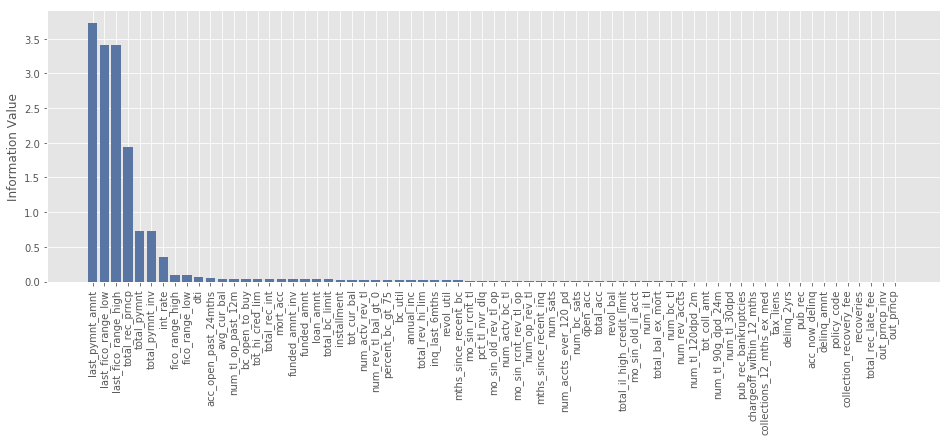

In [135]:
plt.figure(figsize=(16, 5))
plt.bar([x[0] for x in numerical_ft_sorted_iv], [x[1] for x in numerical_ft_sorted_iv], color='#5975A4')
plt.xticks(rotation=90)
plt.ylabel('Information Value')

### Choose numerical features which IV value is >=0.02

In [136]:
# filted_feature_numerical = [ x[0] for x in numerical_ft_sorted_iv if x[1]>=0.02 ] 
filted_feature_numerical = [ x[0] for x in numerical_ft_sorted_iv if 0.02 <= x[1] <= 0.05 ]

len(filted_feature_numerical)

18

In [137]:
filted_feature_numerical

['avg_cur_bal',
 'num_tl_op_past_12m',
 'bc_open_to_buy',
 'tot_hi_cred_lim',
 'total_rec_int',
 'mort_acc',
 'funded_amnt_inv',
 'funded_amnt',
 'loan_amnt',
 'total_bc_limit',
 'installment',
 'tot_cur_bal',
 'num_actv_rev_tl',
 'num_rev_tl_bal_gt_0',
 'percent_bc_gt_75',
 'bc_util',
 'annual_inc',
 'total_rev_hi_lim']

In [138]:
# # filted_feature_numerical  
# # 11 features derived from sampling data.
# last_fico_range_low
# last_fico_range_high
# last_pymnt_amnt
# total_rec_prncp
# total_pymnt
# total_pymnt_inv
# int_rate
# fico_range_low
# fico_range_high
# bc_open_to_buy
# total_bc_limit


In [139]:
# Write filtered numerical features into processed data

In [140]:
# filted_feature = filted_feature_numerical + ['loan_status_code']

In [141]:
# loan_sample_processed = loan_sample_ft[filted_feature]

In [142]:
# loan_sample_processed.to_csv('data/loan_sample_processed.csv')

## Calculate categorical IV

In [143]:
categorical_ft=list(loan_sample_ft.dtypes.loc[lambda x : x == 'object' ].to_dict().keys())

In [144]:
len(categorical_ft)

23

In [145]:
categorical_ft

['emp_title',
 'emp_length',
 'title',
 'last_pymnt_d',
 'last_credit_pull_d',
 'earliest_cr_line',
 'loan_status',
 'issue_d',
 'pymnt_plan',
 'verification_status',
 'home_ownership',
 'hardship_flag',
 'disbursement_method',
 'sub_grade',
 'grade',
 'term',
 'debt_settlement_flag',
 'url',
 'purpose',
 'application_type',
 'zip_code',
 'initial_list_status',
 'addr_state']

## Filter out features which category is more than 20 or only one category.

In [146]:
# Filter out features which category is more than 20 or only one category.
ft_filter_out = np.array([])
for feature_name in categorical_ft:
    ft_size = loan_sample_ft[feature_name].unique().size
    if ft_size > 20 or ft_size == 1:
        ft_filter_out = np.append(ft_filter_out,feature_name)
    else :
        print(feature_name)
        print(loan_sample_ft[feature_name].unique())
        
# print(ft_filter_out)

emp_length
['9 years' '2 years' '8 years' '6 years' '4 years' '1 year' '10+ years'
 '5 years' '< 1 year' '3 years' '7 years' 'unkown']
loan_status
['Fully Paid' 'Does not meet the credit policy. Status:Fully Paid'
 'Charged Off' 'Late (31-120 days)'
 'Does not meet the credit policy. Status:Charged Off' 'Late (16-30 days)'
 'Default']
pymnt_plan
['n' 'y']
verification_status
['Source Verified' 'Verified' 'Not Verified']
home_ownership
['MORTGAGE' 'RENT' 'OWN' 'OTHER' 'ANY' 'NONE']
hardship_flag
['N' 'Y']
disbursement_method
['Cash' 'DirectPay']
grade
['B' 'D' 'A' 'C' 'E' 'G' 'F']
term
[' 36 months' ' 60 months']
debt_settlement_flag
['N' 'Y']
purpose
['credit_card' 'wedding' 'home_improvement' 'debt_consolidation' 'other'
 'car' 'moving' 'small_business' 'major_purchase' 'house' 'vacation'
 'medical' 'renewable_energy' 'educational']
application_type
['Individual' 'Joint App']
initial_list_status
['w' 'f']


## Generate mapping string for dictionary for categorical features to be encoded.

In [147]:
# Generate mapping string for dictionary for categorical features to be encoded.
cat_ft_encoded = np.array([])
for feature_name in categorical_ft:
    if feature_name not in ft_filter_out and feature_name != 'loan_status':
        cat_ft_encoded = np.append(cat_ft_encoded,feature_name)
        print(feature_name)
        map_str = LC_customize.get_map_str(loan_sample_ft[feature_name])
        print(map_str)
        
print(cat_ft_encoded)

emp_length
{'1 year':0, '10+ years':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7, '8 years':8, '9 years':9, '< 1 year':10, 'unkown':11}
pymnt_plan
{'n':0, 'y':1}
verification_status
{'Not Verified':0, 'Source Verified':1, 'Verified':2}
home_ownership
{'ANY':0, 'MORTGAGE':1, 'NONE':2, 'OTHER':3, 'OWN':4, 'RENT':5}
hardship_flag
{'N':0, 'Y':1}
disbursement_method
{'Cash':0, 'DirectPay':1}
grade
{'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
term
{' 36 months':0, ' 60 months':1}
debt_settlement_flag
{'N':0, 'Y':1}
purpose
{'car':0, 'credit_card':1, 'debt_consolidation':2, 'educational':3, 'home_improvement':4, 'house':5, 'major_purchase':6, 'medical':7, 'moving':8, 'other':9, 'renewable_energy':10, 'small_business':11, 'vacation':12, 'wedding':13}
application_type
{'Individual':0, 'Joint App':1}
initial_list_status
{'f':0, 'w':1}
['emp_length' 'pymnt_plan' 'verification_status' 'home_ownership'
 'hardship_flag' 'disbursement_method' 'grade' 'term'
 'd

### Manually encode is needful to avoid of inconsistant encoding. 

In [148]:
map_emp_length = { '< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7, '8 years':8, '9 years':9, '10+ years':10,'none':11}
map_debt_settlement_flag = {'N':0, 'Y':1}
map_purpose = {'car':0, 'credit_card':1, 'debt_consolidation':2, 'educational':3, 'home_improvement':4, 'house':5, 'major_purchase':6, 'medical':7, 'moving':8, 'other':9, 'renewable_energy':10, 'small_business':11, 'vacation':12, 'wedding':13}
map_term = {' 36 months':0, ' 60 months':1}
map_verification_status = {'Not Verified':0, 'Source Verified':1, 'Verified':2}
map_home_ownership = {'ANY':0, 'MORTGAGE':1, 'NONE':2, 'OTHER':3, 'OWN':4, 'RENT':5}
map_disbursement_method = {'Cash':0, 'DirectPay':1}
map_grade = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
map_application_type = {'Individual':0, 'Joint App':1}
map_initial_list_status = {'f':0, 'w':1}
map_pymnt_plan = {'n':0, 'y':1}
map_hardship_flag = {'N':0, 'Y':1}


In [149]:
#print(map_emp_length)
#print(type(map_emp_length))

for feature_name in cat_ft_encoded:
    encode_str = 'map_' + feature_name
    print(eval(encode_str))
        

{'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10, 'none': 11}
{'n': 0, 'y': 1}
{'Not Verified': 0, 'Source Verified': 1, 'Verified': 2}
{'ANY': 0, 'MORTGAGE': 1, 'NONE': 2, 'OTHER': 3, 'OWN': 4, 'RENT': 5}
{'N': 0, 'Y': 1}
{'Cash': 0, 'DirectPay': 1}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
{' 36 months': 0, ' 60 months': 1}
{'N': 0, 'Y': 1}
{'car': 0, 'credit_card': 1, 'debt_consolidation': 2, 'educational': 3, 'home_improvement': 4, 'house': 5, 'major_purchase': 6, 'medical': 7, 'moving': 8, 'other': 9, 'renewable_energy': 10, 'small_business': 11, 'vacation': 12, 'wedding': 13}
{'Individual': 0, 'Joint App': 1}
{'f': 0, 'w': 1}


In [150]:
#loan_sample_ft['emp_length_code'] = loan_sample_ft['emp_length'].map(map_emp_length)

In [151]:
# # Encode categorical features.
# for feature_name in categorical_ft:
#     if feature_name not in ft_filter_out:
#         encode_str = 'map_' + feature_name
#         loan_sample_ft[feature_name] = loan_sample_ft[feature_name].map(encode_str)

In [152]:
iv_model = iv_helper.CIV(loan_sample_ft['home_ownership'], loan_sample_ft['loan_status_code'])
iv_value = iv_model.eval(num_bins=6, bins_threshold=3, chi2_threshold=0.5)
print(iv_value)

0.03212498663025059


In [153]:
# Calculate IV for categorical features which is to be encoded.

dict_iv_category = dict()

for feature_name in cat_ft_encoded:
    iv_model = iv_helper.CIV(loan_sample_ft[feature_name], loan_sample_ft['loan_status_code'])
    iv_value = iv_model.eval(num_bins=6, bins_threshold=3, chi2_threshold=0.5)
    dict_iv_category[feature_name] = iv_value

In [154]:
dict_iv_category

{'emp_length': 0.011543432750266905,
 'pymnt_plan': 0.07626939212981321,
 'verification_status': 0.04693858457208168,
 'home_ownership': 0.03212498663025059,
 'hardship_flag': 0.09714896773237611,
 'disbursement_method': 0.0007733087153596592,
 'grade': 0.43937920971478484,
 'term': 0.17880227853476394,
 'debt_settlement_flag': 1.0432672877109999,
 'purpose': 0.020421420881226043,
 'application_type': 0.006680068821678514,
 'initial_list_status': 0.003585682045614004}

In [155]:
len(dict_iv_category)

12

In [156]:
categorical_ft_sorted_iv = sorted(dict_iv_category.items(), key=lambda x: x[1], reverse=True)

Text(0, 0.5, 'Categorical Information Value')

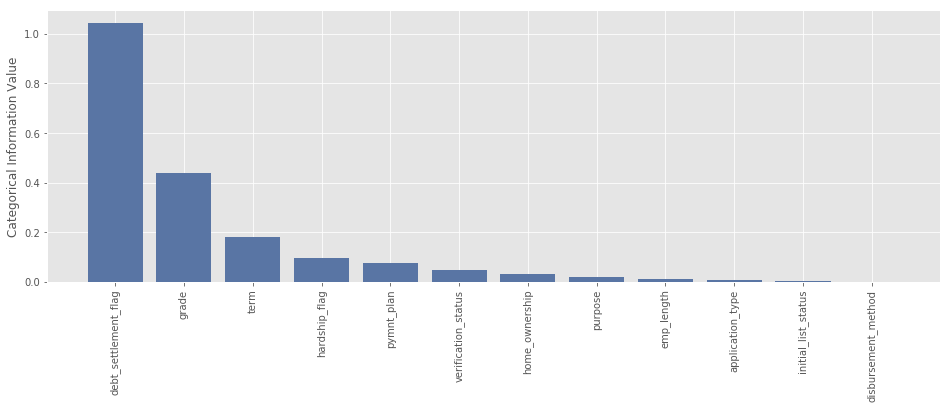

In [157]:
plt.figure(figsize=(16, 5))
plt.bar([x[0] for x in categorical_ft_sorted_iv], [x[1] for x in categorical_ft_sorted_iv], color='#5975A4')
plt.xticks(rotation=90)
plt.ylabel('Categorical Information Value')

## Choose categorical features which IV value is between 0.02 and 0.05

In [158]:
filted_feature_categorical_by_IV = [ x[0] for x in categorical_ft_sorted_iv if 0.02 <= x[1] <= 0.05 ] 

In [159]:
len(filted_feature_categorical_by_IV)

3

In [160]:
filted_feature_categorical_by_IV

['verification_status', 'home_ownership', 'purpose']

In [161]:
# # filted_feature_categorical_by_IV using sample data.
# debt_settlement_flag
# grade
# term
# home_ownership


In [162]:
# Encode selected categorical features
filted_feature_categorical = np.array([])

for feature_name in filted_feature_categorical_by_IV:
    if feature_name in cat_ft_encoded:
        encode_str = 'map_' + feature_name
        filted_feature_categorical = np.append(filted_feature_categorical,feature_name)
        loan_sample_ft[feature_name] = loan_sample_ft[feature_name].map(eval(encode_str))
        
print(filted_feature_categorical)

['verification_status' 'home_ownership' 'purpose']


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [163]:
loan_sample_ft['grade'].head()

0    B
1    D
2    A
3    B
4    A
Name: grade, dtype: object

In [164]:
filted_feature = filted_feature_numerical + filted_feature_categorical.tolist() + ['loan_status_code']

In [165]:
filted_feature

['avg_cur_bal',
 'num_tl_op_past_12m',
 'bc_open_to_buy',
 'tot_hi_cred_lim',
 'total_rec_int',
 'mort_acc',
 'funded_amnt_inv',
 'funded_amnt',
 'loan_amnt',
 'total_bc_limit',
 'installment',
 'tot_cur_bal',
 'num_actv_rev_tl',
 'num_rev_tl_bal_gt_0',
 'percent_bc_gt_75',
 'bc_util',
 'annual_inc',
 'total_rev_hi_lim',
 'verification_status',
 'home_ownership',
 'purpose',
 'loan_status_code']

In [166]:
len(filted_feature)

22

In [167]:
loan_sample_processed = loan_sample_ft[filted_feature]

In [168]:
loan_sample_processed.head()

,avg_cur_bal,num_tl_op_past_12m,bc_open_to_buy,tot_hi_cred_lim,total_rec_int,mort_acc,funded_amnt_inv,funded_amnt,loan_amnt,total_bc_limit,...,num_actv_rev_tl,num_rev_tl_bal_gt_0,percent_bc_gt_75,bc_util,annual_inc,total_rev_hi_lim,verification_status,home_ownership,purpose,loan_status_code
0,36431.0,2.0,4917.0,445842.0,1163.01,1.0,6400.0,6400.0,6400.0,14000.0,...,5.0,6.0,66.7,64.9,65000.0,27900.0,1,1,1,0
1,4326.0,1.0,5299.0,34156.0,3492.65,0.0,14200.0,14200.0,14200.0,13000.0,...,3.0,3.0,50.0,59.2,60000.0,18700.0,2,5,13,0
2,21254.0,3.0,7940.0,326070.0,819.48,1.0,10000.0,10000.0,10000.0,9000.0,...,2.0,2.0,0.0,11.8,60000.0,35400.0,1,1,4,0
3,11980.0,3.0,4003.0,125737.0,723.98,2.0,7025.0,7025.0,7025.0,9800.0,...,3.0,3.0,0.0,59.2,35000.0,15500.0,0,1,2,0
4,2990.0,1.0,29650.0,44600.0,225.04,2.0,12000.0,12000.0,12000.0,44600.0,...,5.0,5.0,20.0,33.5,96000.0,44600.0,2,1,2,0


In [169]:
# loan_sample_processed = loan_sample_processed.drop(["loan_status"], axis = 1)

In [170]:
loan_sample_processed.describe()

,avg_cur_bal,num_tl_op_past_12m,bc_open_to_buy,tot_hi_cred_lim,total_rec_int,mort_acc,funded_amnt_inv,funded_amnt,loan_amnt,total_bc_limit,...,num_actv_rev_tl,num_rev_tl_bal_gt_0,percent_bc_gt_75,bc_util,annual_inc,total_rev_hi_lim,verification_status,home_ownership,purpose,loan_status_code
count,129769.000000,129769.000000,129769.000000,1.297690e+05,129769.000000,129769.000000,129769.000000,129769.000000,129769.000000,129769.000000,...,129769.000000,129769.000000,129769.000000,129769.000000,1.297690e+05,1.297690e+05,129769.000000,129769.000000,129769.000000,129769.000000
mean,13164.108292,2.071250,9571.492213,1.710551e+05,2402.410812,1.610685,14413.900723,14442.828410,14450.735345,21258.192218,...,5.358152,5.311176,45.212315,60.257656,7.633730e+04,3.227350e+04,1.014087,2.911682,2.700267,0.218743
std,15957.214893,1.860012,14883.881361,1.737850e+05,2589.726665,1.992253,8719.080369,8712.682913,8715.868405,20890.314225,...,3.459165,3.382607,35.079900,27.532394,7.241442e+04,3.295856e+04,0.783949,1.915431,2.390119,0.413395
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,500.000000,500.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3259.000000,1.000000,1112.000000,5.209300e+04,765.410000,0.000000,7900.000000,8000.000000,8000.000000,8000.000000,...,3.000000,3.000000,14.300000,40.000000,4.560000e+04,1.460000e+04,0.000000,1.000000,2.000000,0.000000
50%,7423.000000,2.000000,4197.000000,1.126080e+05,1570.550000,1.000000,12000.000000,12000.000000,12000.000000,15000.000000,...,5.000000,5.000000,42.900000,63.400000,6.500000e+04,2.400000e+04,1.000000,4.000000,2.000000,0.000000
75%,17827.000000,3.000000,11645.000000,2.422520e+05,3055.650000,3.000000,20000.000000,20000.000000,20000.000000,27300.000000,...,7.000000,7.000000,75.000000,83.900000,9.000000e+04,3.930000e+04,2.000000,5.000000,2.000000,0.000000
max,447433.000000,24.000000,283705.000000,9.999999e+06,26611.430000,28.000000,40000.000000,40000.000000,40000.000000,363900.000000,...,57.000000,44.000000,100.000000,178.300000,9.500000e+06,1.998700e+06,2.000000,5.000000,13.000000,1.000000


In [171]:
loan_sample_processed.to_csv('data/loan_sample_processed_10pct.csv')